In [3]:
# %%
# Run this once if the packages are not installed yet
# !pip install pillow pandas matplotlib torch torchvision torchaudio

In [4]:
# %%
import os
import re
import glob
import tarfile
import csv
import math
from typing import List, Tuple

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from tqdm.auto import tqdm

# Matches grayscale  "1x1", "32x18"
# and color pixels   "1x1_r", "1x1_g", "1x1_b"
PIXEL_RE = re.compile(r"^\d+x\d+(?:_[rgb])?$")

# Filename pattern for Edinburgh frames
FILENAME_RE = re.compile(
    r"inspacecam163_(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})_(\d{2})\.jpg$"
)

In [5]:
# %%
# Path to PCA embedding CSV created, e.g., by the autoencoder+PCA notebook.
pca_embedding_csv_path = os.path.join(
    "autoencoder_runs",
    "ae_edinburgh-office-data_w128h72_gray_tw150000-150959_step1_ae_cnn_pca_whitening_seed0_latent_pca.csv"
)

print("Using PCA embedding CSV:", pca_embedding_csv_path)


Using PCA embedding CSV: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_tw150000-150959_step1_ae_cnn_pca_whitening_seed0_latent_pca.csv


In [6]:
# %%
def parse_time_from_filename(name):
    """Returns (hour, minute, second) or None if the filename does not match."""
    base = os.path.basename(name)
    m = FILENAME_RE.match(base)
    if not m:
        return None
    h = int(m.group(4))
    m_ = int(m.group(5))
    s = int(m.group(6))
    return h, m_, s


def seconds_since_midnight(h, m, s):
    return h * 3600 + m * 60 + s


def parse_time_string(s):
    """
    Parse HH:MM or HH:MM:SS -> seconds since midnight.
    """
    parts = s.split(":")
    if len(parts) == 2:
        h, m = parts
        s_val = 0
    elif len(parts) == 3:
        h, m, s_val = parts
    else:
        raise ValueError(f"Invalid time format: {s!r}. Expected HH:MM or HH:MM:SS")
    h_i = int(h)
    m_i = int(m)
    s_i = int(s_val)
    if not (0 <= h_i < 24 and 0 <= m_i < 60 and 0 <= s_i < 60):
        raise ValueError(f"Time out of range: {s!r}")
    return seconds_since_midnight(h_i, m_i, s_i)


def time_filter(day_sec, start_sec, end_sec, use_all_times):
    if use_all_times:
        return True
    return start_sec <= day_sec <= end_sec

In [7]:
# %%
def list_tar_files(folder):
    pattern = os.path.join(folder, "day_*.tar")
    tar_paths = sorted(glob.glob(pattern))
    if not tar_paths:
        raise SystemExit(f"No tar files matching 'day_*.tar' found in {folder}")
    return tar_paths


def first_pass_lengths(tar_paths, start_sec, end_sec, use_all_times, frame_step):
    """
    First pass: determine, for each tar, how many kept frames (after subsampling)
    fall into the specified time window (or all times if use_all_times is True).

    Returns:
      - line_index_by_path: {tar_path -> line_id}
      - line_length_by_path: {tar_path -> number_of_kept_frames}
      - global_max_step: maximum step index across all lines
    """
    line_index_by_path = {}
    line_length_by_path = {}
    line_lengths = []

    line_counter = 0

    for path in tqdm(tar_paths, desc="First pass: counting frames"):
        with tarfile.open(path, "r") as tar:
            times = []
            for member in tar.getmembers():
                if not member.isfile():
                    continue
                t = parse_time_from_filename(member.name)
                if t is None:
                    continue
                h, m, s = t
                day_sec = seconds_since_midnight(h, m, s)
                if time_filter(day_sec, start_sec, end_sec, use_all_times):
                    times.append(day_sec)

        times.sort()
        if times:
            kept_len = (len(times) + frame_step - 1) // frame_step
            line_index_by_path[path] = line_counter
            line_length_by_path[path] = kept_len
            line_lengths.append(kept_len)
            line_counter += 1

    if not line_lengths:
        raise SystemExit("No frames found in the specified time window.")

    max_len = max(line_lengths)
    global_max_step = max_len - 1 if max_len > 1 else 0

    return line_index_by_path, line_length_by_path, global_max_step


In [8]:
# %%
def build_header(width, height, grayscale):
    header = [
        "id",
        "line",
        "label",
        "step",
        "daytimestamp",
        "daytime",
        "action",
        "age",
        "age_global",
    ]
    # Pixel columns; grayscale: <x>x<y>
    # Color: <x>x<y>_r, <x>x<y>_g, <x>x<y>_b
    for x in range(1, width + 1):
        for y in range(1, height + 1):
            if grayscale:
                header.append(f"{x}x{y}")
            else:
                header.append(f"{x}x{y}_r")
                header.append(f"{x}x{y}_g")
                header.append(f"{x}x{y}_b")
    return header


def extract_pixels(img_fileobj, width, height, grayscale):
    """
    Open image, convert to target mode and size, and return a flat list of values.
    Grayscale: one value per pixel.
    Color: three values (R, G, B) per pixel.

    Pixel order matches the original implementation:
    outer loop over x (0..width-1), inner loop over y (0..height-1).
    """
    with Image.open(img_fileobj) as img:
        if grayscale:
            img = img.convert("L")
        else:
            img = img.convert("RGB")
        img = img.resize((width, height), resample=Image.BILINEAR)

        arr = np.asarray(img, dtype=np.uint8)

        if grayscale:
            # arr shape: (height, width)
            # Original order: for x in range(width) for y in range(height): pixels[x,y]
            # That corresponds to arr.T flattened row-major.
            return arr.T.reshape(-1).tolist()
        else:
            # arr shape: (height, width, 3)
            # Want order: x outer, y inner, then (r,g,b) per pixel.
            arr = arr.transpose(1, 0, 2)   # (width, height, 3)
            return arr.reshape(-1, 3).reshape(-1).tolist()

In [9]:
# %%
def second_pass_write_csv(
    tar_paths,
    line_index_by_path,
    line_length_by_path,
    global_max_step,
    start_sec,
    end_sec,
    use_all_times,
    frame_step,
    width,
    height,
    grayscale,
    output_path,
):
    header = build_header(width, height, grayscale)
    global_id = 0
    total_rows = 0

    # Total number of frames to be written, for progress bar
    total_to_write = sum(line_length_by_path.values())

    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

        with tqdm(total=total_to_write, desc="Second pass: writing CSV") as pbar:
            for path in tar_paths:
                if path not in line_index_by_path:
                    continue  # no frames in window

                line_id = line_index_by_path[path]
                line_len = line_length_by_path[path]

                frames = []
                with tarfile.open(path, "r") as tar:
                    for member in tar.getmembers():
                        if not member.isfile():
                            continue
                        t = parse_time_from_filename(member.name)
                        if t is None:
                            continue
                        h, m, s = t
                        day_sec = seconds_since_midnight(h, m, s)
                        if not time_filter(day_sec, start_sec, end_sec, use_all_times):
                            continue
                        time_str = f"{h:02d}:{m:02d}:{s:02d}"
                        frames.append((day_sec, time_str, member))

                    frames.sort(key=lambda x: x[0])
                    frames = frames[::frame_step]

                    for step, (day_sec, time_str, member) in enumerate(frames):
                        if line_len > 1:
                            age = step / (line_len - 1)
                        else:
                            age = 0.0

                        if global_max_step > 0:
                            age_global = step / global_max_step
                        else:
                            age_global = 0.0

                        img_fileobj = tar.extractfile(member)
                        if img_fileobj is None:
                            continue

                        pixel_values = extract_pixels(
                            img_fileobj,
                            width=width,
                            height=height,
                            grayscale=grayscale,
                        )

                        row = [
                            global_id,          # id
                            line_id,            # line (trajectory/day id)
                            "",                 # label
                            step,               # step
                            day_sec,            # daytimestamp
                            time_str,           # daytime
                            "",                 # action
                            f"{age:.6f}",       # age
                            f"{age_global:.6f}" # age_global
                        ] + pixel_values

                        writer.writerow(row)
                        global_id += 1
                        total_rows += 1
                        pbar.update(1)

    print(f"Wrote {total_rows} rows to {output_path}")


In [10]:
# %%
def make_trajectory_filename(
    output_dir,
    width,
    height,
    grayscale,
    use_all_times,
    start_time,
    end_time,
    frame_step,
):
    """
    Create a unique filename for trajectories based on key parameters.
    """
    mode = "gray" if grayscale else "rgb"
    if use_all_times:
        tw = "all"
    else:
        tw = f"{start_time.replace(':','')}-{end_time.replace(':','')}"
    name = f"trajectories_w{width}h{height}_{mode}_tw{tw}_step{frame_step}.csv"
    return os.path.join(output_dir, name)


def build_trajectories_csv(
    folder,
    output_dir=".",
    output_path=None,
    width=128,
    height=72,
    grayscale=True,
    start_time="15:00:00",
    end_time="15:09:59",
    use_all_times=False,
    frame_step=1,
    target_max_samples=None,
):
    """
    Build trajectory CSV from Edinburgh office monitoring tar files.

    Each row = one frame (downsampled image).
    'line' encodes the day/trajectory id, 'step' encodes the time order within line.

    If target_max_samples is given (>0) and frame_step == 1,
    frame_step is chosen automatically so that total kept frames
    are <= target_max_samples (uniform subsampling in time).
    """
    if frame_step <= 0:
        raise ValueError("frame_step must be >= 1")

    os.makedirs(output_dir, exist_ok=True)

    tar_paths = list_tar_files(folder)

    if use_all_times:
        start_sec = 0
        end_sec = 24 * 3600 - 1
    else:
        start_sec = parse_time_string(start_time)
        end_sec = parse_time_string(end_time)
        if end_sec < start_sec:
            raise ValueError("end_time must be >= start_time")

    # Auto-determine frame_step from target_max_samples (no randomness)
    if target_max_samples is not None and target_max_samples > 0 and frame_step == 1:
        # First pass with frame_step=1 to get total frame count
        _, line_length_by_path_full, _ = first_pass_lengths(
            tar_paths,
            start_sec,
            end_sec,
            use_all_times,
            frame_step=1,
        )
        total_frames = sum(line_length_by_path_full.values())
        if total_frames == 0:
            raise SystemExit("No frames found in the specified time window.")

        auto_step = max(1, math.ceil(total_frames / target_max_samples))
        frame_step = auto_step

        print(
            f"Auto frame_step={frame_step} based on target_max_samples={target_max_samples} "
            f"(total base frames={total_frames}, "
            f"approx kept={math.ceil(total_frames / frame_step)})"
        )

    # Decide output filename (includes final frame_step)
    if output_path is None:
        output_path = make_trajectory_filename(
            output_dir=output_dir,
            width=width,
            height=height,
            grayscale=grayscale,
            use_all_times=use_all_times,
            start_time=start_time,
            end_time=end_time,
            frame_step=frame_step,
        )
    else:
        out_dir = os.path.dirname(output_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)

    (
        line_index_by_path,
        line_length_by_path,
        global_max_step,
    ) = first_pass_lengths(
        tar_paths,
        start_sec,
        end_sec,
        use_all_times,
        frame_step,
    )

    print(f"Found {len(line_index_by_path)} trajectories (days)")
    print(
        f"Total kept frames={sum(line_length_by_path.values())} "
        f"with frame_step={frame_step}"
    )

    second_pass_write_csv(
        tar_paths,
        line_index_by_path,
        line_length_by_path,
        global_max_step,
        start_sec,
        end_sec,
        use_all_times,
        frame_step,
        width,
        height,
        grayscale,
        output_path,
    )

    return output_path

In [11]:
# %%
# === GLOBAL CONFIG ===
SEED = 0  # kept for compatibility if needed

edinburgh_folder = "."   # <- adjust this path
trajectories_output_dir = "trajectories"
embeddings_output_dir   = "embeddings"

# Time window / resolution settings
width = 128
height = 72
grayscale = True       # False = keep RGB
use_all_times = False   # True = ignore time window
start_time = "15:00:00"
end_time   = "15:09:59"

# Subsampling:
# Option A: manual frame_step (ignored if target_max_samples is set and frame_step==1)
frame_step = 1

# Option B: automatic subsampling to aim for <= target_max_samples total frames
target_max_samples = None   # None to disable auto-selection

os.makedirs(trajectories_output_dir, exist_ok=True)
os.makedirs(embeddings_output_dir, exist_ok=True)

# Determine expected trajectory CSV filename for these settings
traj_csv_path = make_trajectory_filename(
    output_dir=trajectories_output_dir,
    width=width,
    height=height,
    grayscale=grayscale,
    use_all_times=use_all_times,
    start_time=start_time,
    end_time=end_time,
    frame_step=frame_step,
)

if not os.path.exists(traj_csv_path):
    print("Trajectory CSV not found; building it now...")
    traj_csv_path = build_trajectories_csv(
        folder=edinburgh_folder,
        output_dir=trajectories_output_dir,
        output_path=traj_csv_path,
        width=width,
        height=height,
        grayscale=grayscale,
        start_time=start_time,
        end_time=end_time,
        use_all_times=use_all_times,
        frame_step=frame_step,
        target_max_samples=target_max_samples,
    )
else:
    print("Using existing trajectory CSV:", traj_csv_path)

print("Trajectory CSV ready:", traj_csv_path)


Using existing trajectory CSV: trajectories\trajectories_w128h72_gray_tw150000-150959_step1.csv
Trajectory CSV ready: trajectories\trajectories_w128h72_gray_tw150000-150959_step1.csv


In [12]:
# %%
# Stream the trajectory CSV and the PCA embedding CSV in parallel,
# write a new CSV with PCA x,y appended, and collect data for a scatterplot.

base_traj = os.path.splitext(os.path.basename(traj_csv_path))[0]
traj_pca_csv_path = os.path.join(
    embeddings_output_dir,
    f"{base_traj}_pca_latent.csv",
)

print("Trajectory CSV       :", traj_csv_path)
print("PCA embedding CSV    :", pca_embedding_csv_path)
print("Writing combined CSV :", traj_pca_csv_path)

lines_for_plot: List[int] = []
xs_for_plot: List[float] = []
ys_for_plot: List[float] = []

with open(traj_csv_path, "r", newline="") as f_traj, open(
    pca_embedding_csv_path, "r", newline=""
) as f_pca, open(traj_pca_csv_path, "w", newline="") as f_out:
    traj_reader = csv.reader(f_traj)
    pca_reader = csv.reader(f_pca)
    writer = csv.writer(f_out)

    # Headers
    try:
        traj_header = next(traj_reader)
    except StopIteration:
        raise SystemExit("Trajectory CSV is empty.")

    try:
        pca_header = next(pca_reader)
    except StopIteration:
        raise SystemExit("PCA embedding CSV is empty.")

    # Indices needed from both files
    try:
        line_idx = traj_header.index("line")
    except ValueError as e:
        raise SystemExit("Column 'line' not found in trajectory CSV header.") from e

    try:
        pca_x_idx = pca_header.index("pca_x")
        pca_y_idx = pca_header.index("pca_y")
    except ValueError as e:
        raise SystemExit("PCA CSV must contain 'pca_x' and 'pca_y' columns.") from e

    # Optional safety: if there is an 'idx' column, ensure it matches the trajectory id
    idx_idx = pca_header.index("idx") if "idx" in pca_header else None

    # New header: trajectory columns + PCA x,y
    writer.writerow(traj_header + ["x", "y"])

    row_count = 0

    for traj_row in tqdm(traj_reader, desc="Joining PCA embedding"):
        if not traj_row:
            continue

        try:
            pca_row = next(pca_reader)
        except StopIteration:
            raise SystemExit(
                "PCA embedding CSV has fewer rows than the trajectory CSV."
            )

        if idx_idx is not None:
            try:
                traj_id = int(traj_row[0])
                pca_idx_val = int(pca_row[idx_idx])
                if traj_id != pca_idx_val:
                    raise SystemExit(
                        f"Row mismatch at row {row_count}: "
                        f"trajectory id={traj_id}, PCA idx={pca_idx_val}"
                    )
            except ValueError:
                # If parsing fails, skip the strict id check for this row
                pass

        pca_x = float(pca_row[pca_x_idx])
        pca_y = float(pca_row[pca_y_idx])

        writer.writerow(traj_row + [pca_x, pca_y])

        lines_for_plot.append(int(traj_row[line_idx]))
        xs_for_plot.append(pca_x)
        ys_for_plot.append(pca_y)

        row_count += 1

    # Check if PCA file has extra rows
    extra = next(pca_reader, None)
    if extra is not None:
        raise SystemExit(
            "PCA embedding CSV has more rows than the trajectory CSV."
        )

print("Saved PCA-augmented CSV to:", traj_pca_csv_path)
print("Total points joined:", len(xs_for_plot))


Trajectory CSV       : trajectories\trajectories_w128h72_gray_tw150000-150959_step1.csv
PCA embedding CSV    : autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_tw150000-150959_step1_ae_cnn_pca_whitening_seed0_latent_pca.csv
Writing combined CSV : embeddings\trajectories_w128h72_gray_tw150000-150959_step1_pca_latent.csv


Joining PCA embedding: 0it [00:00, ?it/s]

Saved PCA-augmented CSV to: embeddings\trajectories_w128h72_gray_tw150000-150959_step1_pca_latent.csv
Total points joined: 5311


Saved PCA latent scatterplot to: embeddings\trajectories_w128h72_gray_tw150000-150959_step1_pca_latent_scatter.png


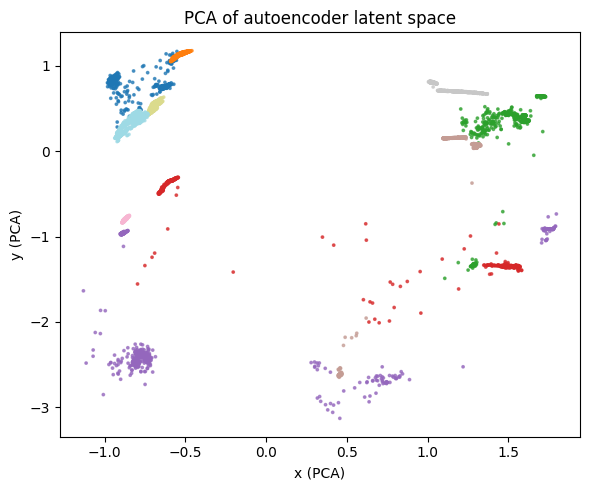

In [13]:
# %%
# Create scatterplot colored by line (trajectory/day id) using PCA embedding
lines_array = np.array(lines_for_plot)
xs_array = np.array(xs_for_plot, dtype=np.float32)
ys_array = np.array(ys_for_plot, dtype=np.float32)

cat = pd.Categorical(lines_array)
codes = cat.codes  # 0..K-1

plt.figure(figsize=(6, 5))
plt.scatter(
    xs_array,
    ys_array,
    c=codes,
    s=3,
    alpha=0.7,
    cmap="tab20",
)
plt.xlabel("x (PCA)")
plt.ylabel("y (PCA)")
plt.title("PCA of autoencoder latent space")
plt.tight_layout()

pca_plot_path = os.path.join(
    embeddings_output_dir,
    f"{base_traj}_pca_latent_scatter.png",
)
plt.savefig(pca_plot_path, dpi=300)
print("Saved PCA latent scatterplot to:", pca_plot_path)
plt.show()


## Subsample AE-embedded trajectories CSV by time window + frame_step

This cell is self-contained: it can be run in a fresh notebook
to create a new subsampled CSV from a previously saved AE-latent CSV.


In [14]:
# %%
# Subsample PCA-embedded trajectories CSV by time window + frame_step
# Streaming version that does not load the entire CSV into memory.

import os
import csv
from typing import Dict
from tqdm.auto import tqdm


def parse_time_string(s: str) -> int:
    """
    Parse HH:MM or HH:MM:SS -> seconds since midnight.
    """
    parts = s.split(":")
    if len(parts) == 2:
        h, m = parts
        s_val = 0
    elif len(parts) == 3:
        h, m, s_val = parts
    else:
        raise ValueError(f"Invalid time format: {s!r}. Expected HH:MM or HH:MM:SS")
    h_i = int(h)
    m_i = int(m)
    s_i = int(s_val)
    if not (0 <= h_i < 24 and 0 <= m_i < 60 and 0 <= s_i < 60):
        raise ValueError(f"Time out of range: {s!r}")
    return h_i * 3600 + m_i * 60 + s_i


# === CONFIG ===
# Path to the full PCA-augmented trajectories CSV created earlier
base_traj = os.path.splitext(os.path.basename(traj_csv_path))[0]
input_csv_path = os.path.join(
    embeddings_output_dir,
    f"{base_traj}_pca_latent.csv",  # adjust if needed
)

# Where to write the subsampled CSV
output_dir = "embeddings_subsamples"

# Time window / subsampling settings
use_all_times = False          # True = ignore start_time/end_time and keep all times
start_time    = "15:00:00"    # HH:MM or HH:MM:SS
end_time      = "15:09:59"
frame_step    = 1            # keep every N-th frame per line after time filtering


# === BASIC CHECKS ===
if frame_step <= 0:
    raise ValueError("frame_step must be >= 1")

if not os.path.exists(input_csv_path):
    raise SystemExit(f"Input CSV not found: {input_csv_path}")

if use_all_times:
    tw_str = "all"
else:
    start_sec = parse_time_string(start_time)
    end_sec = parse_time_string(end_time)
    if end_sec < start_sec:
        raise ValueError("end_time must be >= start_time")
    tw_str = f"{start_time.replace(':','')}-{end_time.replace(':','')}"


# === STREAMING SUBSAMPLING ===
os.makedirs(output_dir, exist_ok=True)

base_name = os.path.splitext(os.path.basename(input_csv_path))[0]
out_name  = f"{base_name}_sub_tw{tw_str}_step{frame_step}.csv"
out_path  = os.path.join(output_dir, out_name)

print("Reading from:", input_csv_path)
print("Writing to  :", out_path)

kept_rows = 0
total_rows = 0

# Per-line counters over time-filtered rows only
line_counters: Dict[str, int] = {}

with open(input_csv_path, "r", newline="") as f_in, open(out_path, "w", newline="") as f_out:
    reader = csv.reader(f_in)
    writer = csv.writer(f_out)

    # Header
    try:
        header = next(reader)
    except StopIteration:
        raise SystemExit("Input CSV is empty.")

    # Required indices
    try:
        line_idx = header.index("line")
    except ValueError:
        raise SystemExit("Column 'line' not found in CSV header; needed for per-line subsampling.")

    # Prefer integer daytimestamp if available, otherwise daytime string
    daytimestamp_idx = header.index("daytimestamp") if "daytimestamp" in header else -1
    if daytimestamp_idx == -1:
        daytime_idx = header.index("daytime") if "daytime" in header else -1
        if daytime_idx == -1:
            raise SystemExit("Expected either 'daytimestamp' or 'daytime' column for time filtering.")
    else:
        daytime_idx = -1

    # Write header unchanged
    writer.writerow(header)

    for row in tqdm(reader, desc="Subsampling PCA-latent CSV"):
        if not row:
            continue
        total_rows += 1

        line_val = row[line_idx]  # keep as string for dictionary key

        # Time filtering
        if use_all_times:
            time_ok = True
        else:
            if daytimestamp_idx >= 0:
                ts = int(row[daytimestamp_idx])
            else:
                ts = parse_time_string(row[daytime_idx])
            time_ok = (ts >= start_sec) and (ts <= end_sec)

        if not time_ok:
            # Time-filtered out; do not affect frame_step counting within the filtered subset
            continue

        # Per-line index within the time-filtered subset
        idx = line_counters.get(line_val, 0)

        # Keep every N-th row per line
        if idx % frame_step == 0:
            writer.writerow(row)
            kept_rows += 1

        line_counters[line_val] = idx + 1

print(f"Total rows scanned   : {total_rows}")
print(f"Rows kept (subsample): {kept_rows}")

if kept_rows == 0:
    print("No rows remained after filtering and subsampling; removing empty output file.")
    os.remove(out_path)
    raise SystemExit("No rows remained after filtering and subsampling.")
else:
    print("Saved subsampled CSV to:", out_path)


Reading from: embeddings\trajectories_w128h72_gray_tw150000-150959_step1_pca_latent.csv
Writing to  : embeddings_subsamples\trajectories_w128h72_gray_tw150000-150959_step1_pca_latent_sub_tw150000-150959_step1.csv


Subsampling PCA-latent CSV: 0it [00:00, ?it/s]

Total rows scanned   : 5311
Rows kept (subsample): 5311
Saved subsampled CSV to: embeddings_subsamples\trajectories_w128h72_gray_tw150000-150959_step1_pca_latent_sub_tw150000-150959_step1.csv
